# Loading and Extracting the EEG Signal Plots

Extracting EDF parameters from /Users/nileshupraity/Brain-Controlled-Commands-Decoding-Motor-Intentions-from-EEG-Using-Machine-Learning/data/s001r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


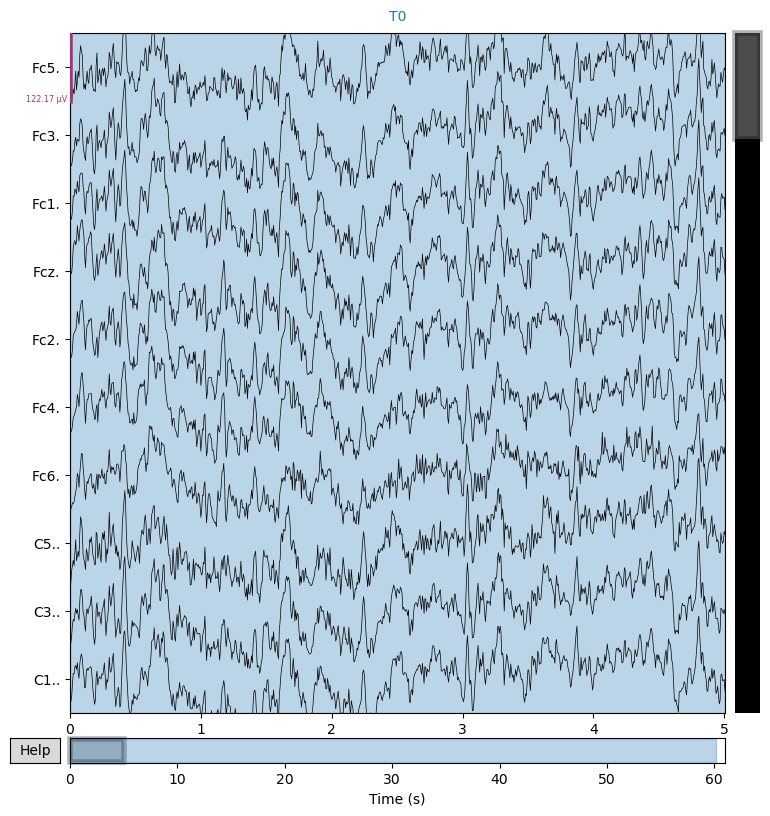

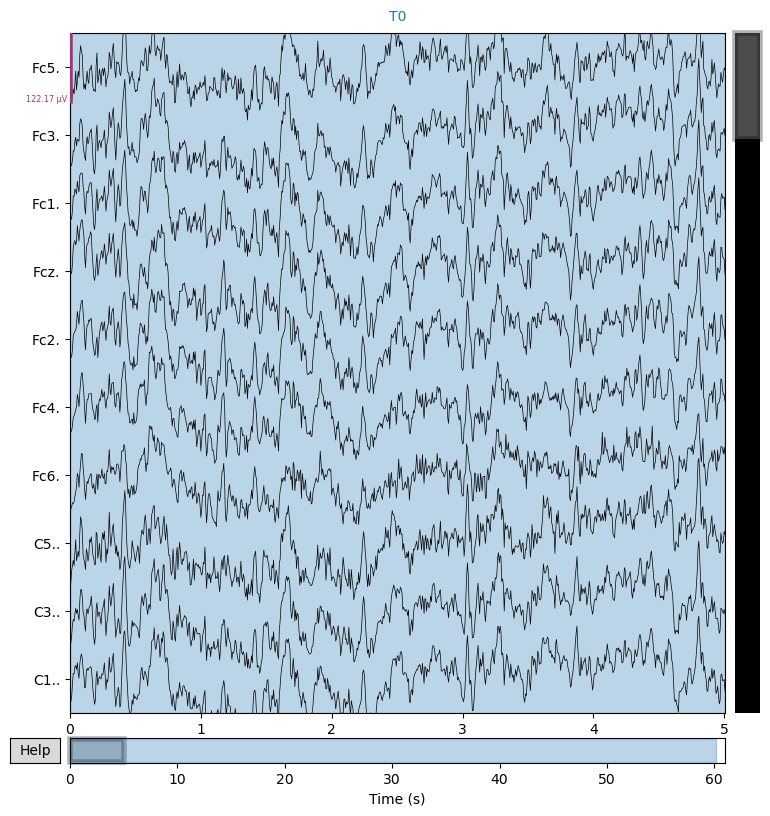

In [15]:
import mne
import matplotlib.pyplot as plt

# Load the EEG .edf file
file_path = "../data/s001r01.edf"
raw = mne.io.read_raw_edf(file_path, preload=True)

# Basic info
print(raw.info)

# Plot EEG signal of first few seconds
raw.plot(n_channels=10, duration=5, scalings='auto')


Annotations: <Annotations | 1 segment: T0 (1)>


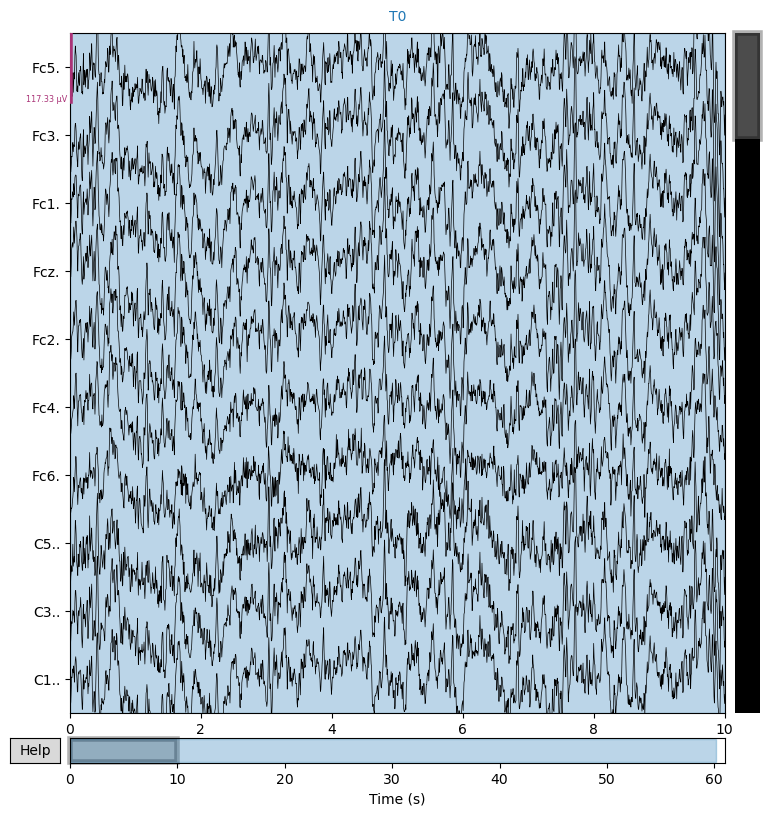

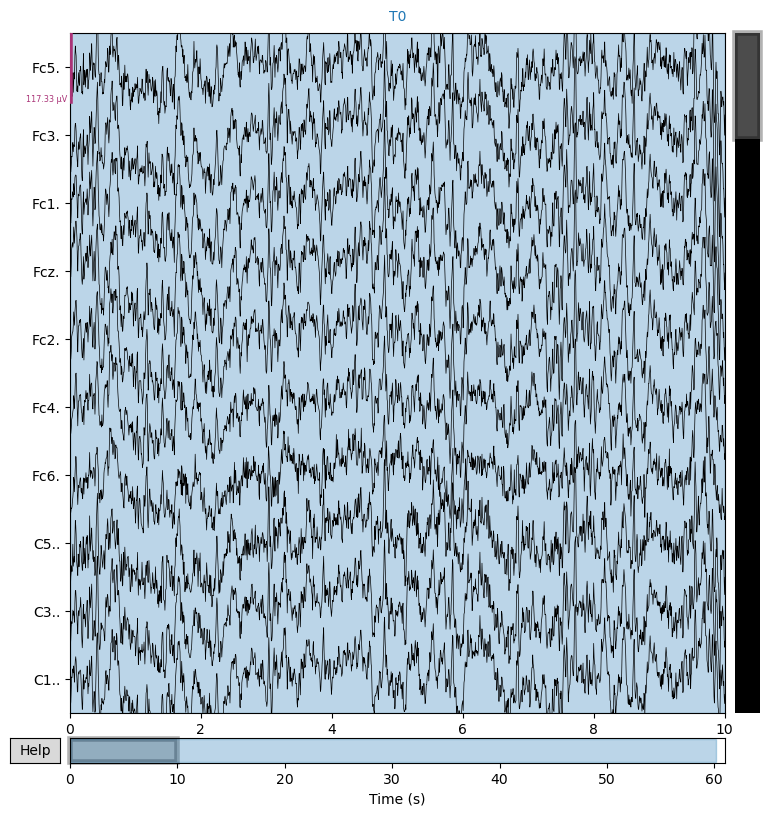

In [17]:
# Show available annotations (events)
print("Annotations:", raw.annotations)

# Or plot them on the signal
raw.plot(duration=10, n_channels=10, scalings='auto', show=True)

# Inspect the EEG Annotations (Event Labels)

In [20]:
file_path = "../data/s001r04.edf"
raw = mne.io.read_raw_edf(file_path, preload=True)

Extracting EDF parameters from /Users/nileshupraity/Brain-Controlled-Commands-Decoding-Motor-Intentions-from-EEG-Using-Machine-Learning/data/s001r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<Annotations | 30 segments: T0 (15), T1 (8), T2 (7)>


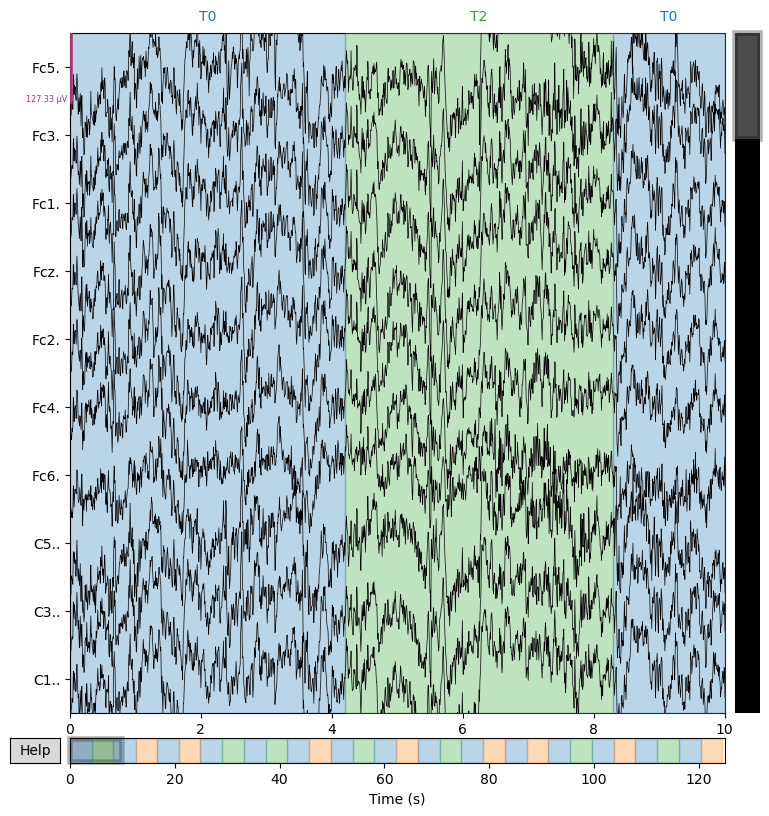

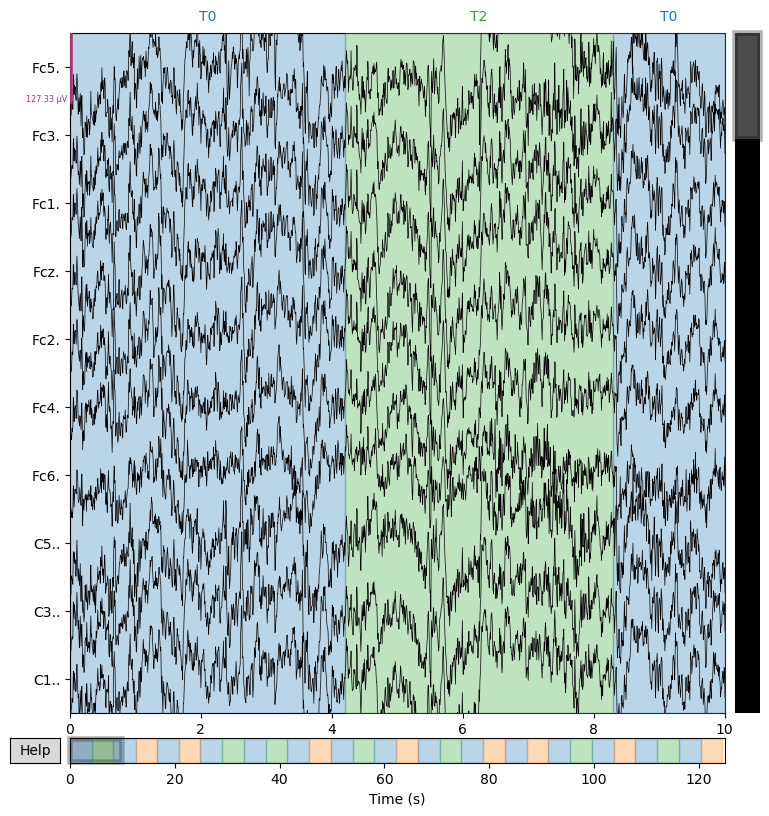

In [22]:
print(raw.annotations)
raw.plot(duration=10, n_channels=10, scalings='auto', show=True)

# Extract Epochs and Build Labels


In [25]:
event_id = {
    'T1': 1,  # Left hand
    'T2': 2,  # Right hand
}

In [29]:
# Convert annotations to machine-readable events
events, _ = mne.events_from_annotations(raw, event_id=event_id)

# Time window around event: 0 to 4 seconds
tmin, tmax = 0.0, 4.0

# Extract epochs for left and right hand
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=None, preload=True)

# Inspect shape and labels
X = epochs.get_data()             # EEG data → shape = (n_samples, n_channels, n_times)
y = epochs.events[:, -1]         # Labels → 1 for left, 2 for right

print("Epochs shape:", X.shape)
print("Labels:", y)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 641 original time points ...
0 bad epochs dropped
Epochs shape: (15, 64, 641)
Labels: [2 1 1 2 2 1 2 1 2 1 1 2 1 2 1]


# Feature Extraction and ML Modelling

### Basic Statistical Features 

In [41]:
import numpy as np

# Flatten each epoch's 64 channels into simple features
# We'll compute mean + std for each channel = 2 features per channel
X_features = []

for epoch in X:
    features = []
    for ch in epoch:
        features.append(np.mean(ch))   # Mean of signal
        features.append(np.std(ch))    # Std dev of signal
    X_features.append(features)

X_features = np.array(X_features)
print("Shape of X_features:", X_features.shape)


Shape of X_features: (15, 128)


### Classifier Training

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       0.25      0.50      0.33         2
           2       0.00      0.00      0.00         3

    accuracy                           0.20         5
   macro avg       0.12      0.25      0.17         5
weighted avg       0.10      0.20      0.13         5

Confusion Matrix:
[[1 1]
 [3 0]]


### Improving Accuracy

In [47]:
import os
import mne
import numpy as np
from scipy.signal import welch

# Config
data_path = "../data"
edf_files = ["s001r04.edf", "s001r08.edf", "s002r04.edf"]
sf = 160  # Sampling frequency
bands = [(8, 12), (12, 30)]  # Alpha and Beta

event_id = {'T1': 1, 'T2': 2}
tmin, tmax = 0.0, 4.0

X_all = []
y_all = []

def compute_band_power(epoch, sf, bands):
    powers = []
    for ch in epoch:
        freqs, psd = welch(ch, sf)
        for band in bands:
            idx = np.logical_and(freqs >= band[0], freqs <= band[1])
            powers.append(np.sum(psd[idx]))
    return powers

# Loop over files
for fname in edf_files:
    file_path = os.path.join(data_path, fname)
    raw = mne.io.read_raw_edf(file_path, preload=True)
    
    events, _ = mne.events_from_annotations(raw, event_id=event_id)
    if len(events) == 0:
        continue
    
    epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, 
                        baseline=None, preload=True)
    
    X = epochs.get_data()
    y = epochs.events[:, -1]
    
    X_power = np.array([compute_band_power(epoch, sf, bands) for epoch in X])
    
    X_all.append(X_power)
    y_all.append(y)

# Combine all
X_all = np.vstack(X_all)
y_all = np.hstack(y_all)

print("Total samples:", X_all.shape[0])
print("Feature shape:", X_all.shape)
print("Labels:", y_all)

Extracting EDF parameters from /Users/nileshupraity/Brain-Controlled-Commands-Decoding-Motor-Intentions-from-EEG-Using-Machine-Learning/data/s001r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 641 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /Users/nileshupraity/Brain-Controlled-Commands-Decoding-Motor-Intentions-from-EEG-Using-Machine-Learning/data/s001r08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data f

In [63]:
bands = [
    (8, 13),   # Mu
    (13, 30),  # Beta
    (30, 45),  # Low Gamma
]


In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_all, test_size=0.3, random_state=42, stratify=y_all
)

In [67]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

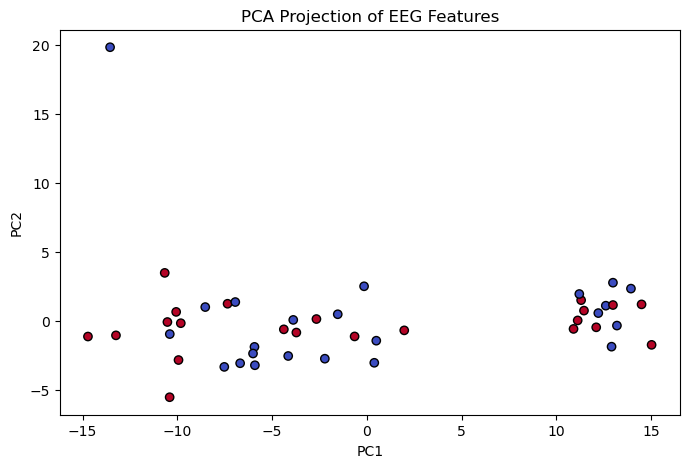

In [69]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_all, cmap='coolwarm', edgecolors='k')
plt.title("PCA Projection of EEG Features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

### SVM Classifer

In [76]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.40      0.57      0.47         7
           2       0.25      0.14      0.18         7

    accuracy                           0.36        14
   macro avg       0.33      0.36      0.33        14
weighted avg       0.33      0.36      0.33        14

[[4 3]
 [6 1]]


In [78]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.67      0.57      0.62         7
           2       0.62      0.71      0.67         7

    accuracy                           0.64        14
   macro avg       0.65      0.64      0.64        14
weighted avg       0.65      0.64      0.64        14

[[4 3]
 [2 5]]
